In [1]:
from tape import Ensemble, TimeSeries
from tape.utils import ColumnMapper
from tape.analysis import calc_sf2
from tape.analysis.structure_function.base_argument_container import StructureFunctionArgumentContainer
from pyarrow import parquet
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Working with the TAPE Single Pixel Dataset

## Loading and Pre-Processing

In [2]:
# Initialize the Ensemble
data_path = "/data3/epyc/data3/hipscat/catalogs/tape_test/"
#parquet.read_schema(f"/data3/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17752.parquet", memory_map=True)  # <-- For inspection of the available columns

ens = Ensemble()
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 188.64 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36150,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 188.64 GiB
Comm: tcp://127.0.0.1:41798,Total threads: 8
Dashboard: http://127.0.0.1:37088/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:40103,


In [3]:
# Load the dataset into an Ensemble

col_map = ColumnMapper(id_col="_hipscat_index", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)


ens._object.head(5)

/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/dask/dataframe/core.py:5214: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/dask/dataframe/core.py:5214: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


,nobs_g,nobs_i,nobs_r,nobs_total,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,...,zFlags_ps1_otmo,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4996744218186612736,17,0,31,48,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,...,114720,-999.000000,-999.000000,16416,5,0,4438,0.000015,5,0
4996744985459032064,71,2,76,149,b'024321.81-010812.1',6782,56572,285,40.840898,-1.136720,...,115000,-999.000000,-999.000000,16416,5,0,4438,0.000010,5,0
4996747488372195328,17,0,19,36,b'024315.98-010433.7',4240,55455,202,40.816592,-1.076055,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000017,5,0
4996749076859977728,85,3,82,170,b'024328.22-010352.7',6782,56572,298,40.867601,-1.064654,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000005,5,0
4996749735944519680,252,6,265,523,b'024341.05-010243.3',4240,55455,178,40.921044,-1.045386,...,115000,19.193501,0.039844,115000,5,0,4438,0.000016,5,0


In [4]:
# Numeric Band Conversions - Has to be done manually the moment

label_df = ens._source[["filterID_ps_source"]].replace([1.0,2.0,3.0,4.0,5.0], ["u","g","r","i","z"]).rename(columns={"filterID_ps_source": "band_ps_source"})
ens._source = dd.concat([ens._source, label_df], axis=1)

/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/dask/dataframe/multi.py:1297: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [7]:
# Convert Panstarrs fluxes to Magnitudes -- produces "mag_ps_source" and "mag_ps_source_err" columns
ens.convert_flux_to_mag(8.9, zp_form="mag", out_col_name="mag_ps_source", flux_col="apFlux_ps_source", err_col="apFluxErr_ps_source")
#ens.convert_flux_to_mag("apFlux_ps_source", "zp_ps_source", "apFluxErr_ps_source", zp_form="mag", out_col_name="mag_ps_source")

In [8]:
# Coalescing - Need to combine survey specific columns (fluxes, times, etc)

ens.coalesce(["mjd_ztf_source", "obsTime_ps_source"], 
              "mvp_time", table="source", drop_inputs=True) # time
ens.coalesce(["mag_ztf_source", "mag_ps_source"], 
              "mvp_flux", table="source", drop_inputs=True) # flux
ens.coalesce(["magerr_ztf_source", "mag_ps_source_err"], 
              "mvp_error", table="source", drop_inputs=True) # Error
ens.coalesce(["band_ztf_source", "band_ps_source"], 
              "mvp_band", table="source", drop_inputs=True) # band, ps1 needs another filter table for translation?

#ens.coalesce(["mag_ztf_source", "apFlux_ps_source"], 
#              "mvp_flux", table="source", drop_inputs=True) # flux, potentially a mag/flux difference here
#ens.coalesce(["magerr_ztf_source", "apFluxErr_ps_source"], 
#              "mvp_error", table="source", drop_inputs=True) # Error, potentially a mag/flux difference here

## Analysis

### Batching Structure Function

In [9]:
ens.head("object")

,nobs_g,nobs_i,nobs_r,nobs_total,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,...,zFlags_ps1_otmo,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4996744218186612736,17,0,31,48,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,...,114720,-999.000000,-999.000000,16416,5,0,4438,0.000015,5,0
4996744985459032064,71,2,76,149,b'024321.81-010812.1',6782,56572,285,40.840898,-1.136720,...,115000,-999.000000,-999.000000,16416,5,0,4438,0.000010,5,0
4996747488372195328,17,0,19,36,b'024315.98-010433.7',4240,55455,202,40.816592,-1.076055,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000017,5,0
4996749076859977728,85,3,82,170,b'024328.22-010352.7',6782,56572,298,40.867601,-1.064654,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000005,5,0
4996749735944519680,252,6,265,523,b'024341.05-010243.3',4240,55455,178,40.921044,-1.045386,...,115000,19.193501,0.039844,115000,5,0,4438,0.000016,5,0


In [10]:
arg_container = StructureFunctionArgumentContainer()
arg_container.band_to_calc = ["g","r"]
arg_container.combine = False

In [11]:
ens.prune(30).sf2(argument_container = arg_container)

/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/astro/users/brantd/.conda/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,lc_id,band,dt,sf2,1_sigma
0,4996744218186612736,g,217.494673,-0.004436,0.0
1,4996744218186612736,g,1037.952208,0.027605,0.0
2,4996744218186612736,r,14.969049,0.037458,0.0
3,4996744218186612736,r,115.255781,0.161024,0.0
4,4996744218186612736,r,389.490094,0.021264,0.0
...,...,...,...,...,...
238,4997869293954662400,r,3203.248735,0.040404,0.0
239,4997869293954662400,r,3269.334458,0.080582,0.0
240,4997869293954662400,r,3417.907312,0.047979,0.0
241,4997869293954662400,r,3612.610135,0.040689,0.0


In [12]:
ens.head("source",5)

,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance,mvp_time,mvp_flux,mvp_error,mvp_band
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4996744218186612736,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,6,10000,survey_1,58366.50250,21.129936,0.213649,r
4996744218186612736,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,6,10000,survey_1,59166.31593,21.030849,0.206425,r
4996744218186612736,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,6,10000,survey_1,59170.27003,20.884747,0.195774,r
4996744218186612736,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,6,10000,survey_1,59195.19632,21.524008,0.242377,r
4996744218186612736,b'024311.71-010928.3',7337,56662,360,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,6,10000,survey_1,59521.28617,21.288073,0.225177,r


### Inspecting a Merged Light Curve

In [13]:
ts = ens.query("index == 4996749735944519680", table="source")

ts.select(["SDSS_NAME_dr16q_constant",
                 "mvp_time","mvp_flux",
                 "mvp_error","mvp_band",
                 "zp_ps_source"], table="source")

ts  = TimeSeries().from_dataframe(
            data=ts._source.compute(),
            object_id=4996749735944519680,
            time_label=ens._time_col,
            flux_label=ens._flux_col,
            err_label=ens._err_col,
            band_label=ens._band_col,
        )

# this doesn't work, solutions involve query or map_partitions instead of loc, but loc should really work here
# leaving this for now
# ts = ens.to_timeseries(4996744218186612736)  

In [14]:
ts.data

SDSS_NAME_dr16q_constant  zp_ps_source      mvp_time   mvp_flux  \
band index                                                                   
g    0        b'024341.05-010243.3'           NaN  59622.156560  19.841175   
     1        b'024341.05-010243.3'           NaN  59532.281420  19.837948   
     2        b'024341.05-010243.3'           NaN  59512.385750  19.841900   
     3        b'024341.05-010243.3'           NaN  59530.291760  19.822536   
     4        b'024341.05-010243.3'           NaN  59525.328490  19.831341   
...                             ...           ...           ...        ...   
     265      b'024341.05-010243.3'     24.745001  55535.272923  19.381726   
z    8        b'024341.05-010243.3'     23.342800  56538.643038  20.196626   
r    281      b'024341.05-010243.3'     24.591900  55484.413964  19.592120   
u    5        b'024341.05-010243.3'     24.464600  55508.342384  19.589749   
z    9        b'024341.05-010243.3'     23.175600  56144.636760  20.413669   

            mvp_error mvp_band  
band index                      
g    0       0.108901        g  
     1       0.108667        g  
     2       0.108953        g  
     3       0.107557        g  
     4       0.108191        g  
...               ...      ...  
     265     0.014986        g  
z    8       0.048499        z  
r    281     0.016844        r  
u    5       0.018134        u  
z    9       0.058113        z  

[586 rows x 6 columns]

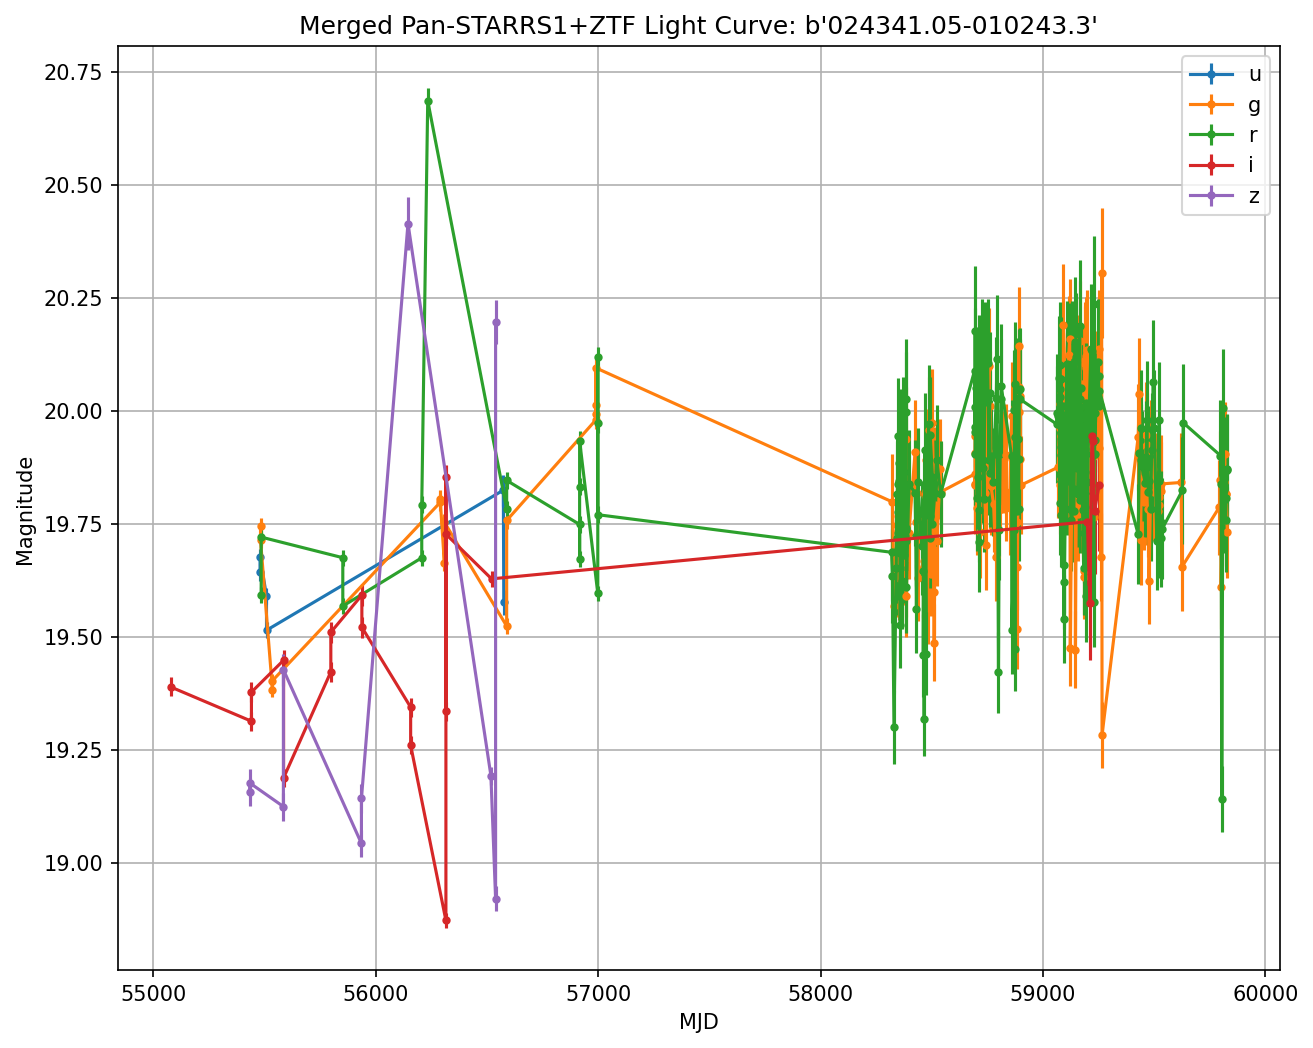

In [15]:
plt.figure(figsize=(10,8), dpi=150)

for i, band in enumerate(["u", "g", "r", "i", "z"]):
    band_df = ts.data.loc[band].sort_values("mvp_time")
    plt.errorbar(band_df["mvp_time"], band_df["mvp_flux"], yerr=band_df["mvp_error"], label=band, marker=".")


plt.title(f"Merged Pan-STARRS1+ZTF Light Curve: {str(ts.data['SDSS_NAME_dr16q_constant'][0])}")
plt.ylabel("Magnitude")
plt.xlabel("MJD")

plt.grid()
plt.legend()